In [1]:
import os
import sys
import pdb
import numpy as np
import scipy.interpolate
import scipy.io
import matlab.engine
import importlib
import soundfile as sf

import matplotlib.pyplot as plt

import port
importlib.reload(port)

import room_simulator
importlib.reload(room_simulator)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [2]:
importlib.reload(port)

# brir_msaddler = port.get_brir(
#     room_materials=[23, 23, 23, 23, 23, 26],
#     room_dim_xyz=[3, 3, 4],
#     head_pos_xyz=[1.4, 1.6, 2.0],
#     head_azim=0,
#     src_azim=35,
#     src_elev=15,
#     src_dist=1.4,
#     buffer_pos=0,
#     sr=44100,
#     dur=0.5,
#     use_jitter=False,
#     incorporate_lead_zeros=False)
# fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room3x3y4z_materials23wall23floor26ciel/15elev_35az_1.40x1.60y2.00z_l.wav'
# y_l, sr = sf.read(fn)
# y_r, sr = sf.read(fn.replace('_l.wav', '_r.wav'))
# brir_francl = np.stack([y_l, y_r], axis=1)

brir_msaddler = port.get_brir(
    room_materials=[1, 1, 1, 1, 15, 16],
    room_dim_xyz=[5, 4, 2],
    head_pos_xyz=[3.6, 1.4, 2.0],
    head_azim=0,
    src_azim=45,
    src_elev=0,
    src_dist=1.4,
    buffer_pos=0,
    sr=44100,
    dur=0.5,
    use_jitter=False,
    incorporate_lead_zeros=False)
fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room5x4y2z_materials1wall15floor16ciel/0elev_45az_3.60x1.40y2.00z_l.wav'
y_l, sr = sf.read(fn)
y_r, sr = sf.read(fn.replace('_l.wav', '_r.wav'))
brir_francl = np.stack([y_l, y_r], axis=1)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [5, 4, 2]
Loaded KEMAR `hrtf_firs` (Gardner & Martin, 1995): (368, 128, 2)
Loaded KEMAR `hrtf_locs` (Gardner & Martin, 1995): (368, 3)
[get_brir] time elapsed: 70.38795900344849 seconds


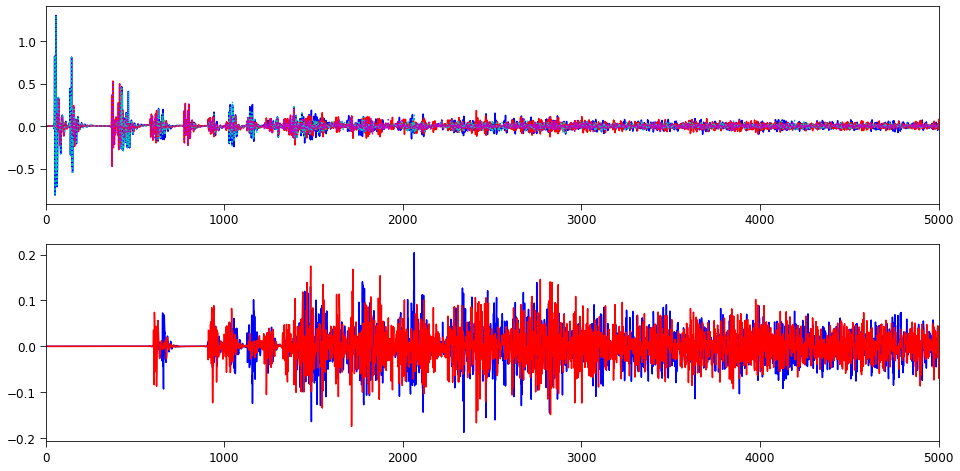

In [3]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)
ax[0].plot(brir_msaddler[:, 0], 'b')
ax[0].plot(brir_msaddler[:, 1], 'r')
ax[0].plot(brir_francl[:, 0], 'c', ls=':')
ax[0].plot(brir_francl[:, 1], 'm', ls=':')

ax[1].plot(brir_francl[:, 0] - brir_msaddler[:, 0], 'b')
ax[1].plot(brir_francl[:, 1] - brir_msaddler[:, 1], 'r')
for ax_ in ax:
    util_figures.format_axes(
        ax_,
        xlimits=[0, 5000]
    )
plt.show()


In [ ]:
eng = matlab.engine.start_matlab();


In [ ]:
src_loc = [1, 2, 4]
head_center = [2, 7, 5]
head_azimuth = 19
walls = [3, 9, 18]
wtypes = [3, 13, 13, 3, 26, 26]
sr = 44100
dur = 0.5
c = 344.5

log_dist = False
jitter = False
highpass = True
meas_sym = True

importlib.reload(port)

h_out, lead_zeros = port.room_impulse_hrtf(
    src_loc=src_loc,
    head_cent=head_center,
    head_azim=head_azimuth,
    use_m_sym=meas_sym,
    walls=walls,
    wtypes=wtypes,
    sr=sr,
    c=c,
    dur=dur,
    use_log_distance=log_dist,
    use_jitter=jitter,
    use_highpass=highpass)
print(lead_zeros)


In [ ]:
h_out_matlab, lead_zeros_matlab = room_simulator.room_impulse_hrtf(
    np.array(src_loc),
    np.array(head_center),
    head_azimuth,
    np.array(walls),
    wtypes,
    meas_sym=meas_sym,
    f_samp=sr,
    c_snd=c,
    num_taps=int(sr*dur),
    log_dist=log_dist,
    jitter=jitter,
    highpass=highpass,
    dsply=0,
    eng=eng)
print(lead_zeros_matlab)


In [ ]:
fig, ax = plt.subplots()
ax.plot(h_out)
plt.show()

fig, ax = plt.subplots()
ax.plot(h_out[1:] - h_out_matlab[:-1])
plt.show()


In [ ]:
import port
import importlib
importlib.reload(port)

h_out, lead_zeros = port.room_impulse_hrtf(jitter=False, meas_sym=1)
print('END')


In [ ]:
fig, ax = plt.subplots()
ax.plot(h_out[:, 0], 'b', lw=0.5)
ax.plot(h_out[:, 1], 'r', lw=0.5)
ax.set_xlim([400, 600])
ax.set_ylim([-0.1, 0.1])
plt.show()


In [ ]:
fn = 'HRTFs/elev0/H0e140a.wav'
sr, y = scipy.io.wavfile.read(fn)
print(sr)

import soundfile as sf
y, sr = sf.read(fn)
print(y.max())
